In [9]:
import glob
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import json

In [29]:
data_dir = 'data_log'
subj = 'R2280'
data_log_dir = f"{data_dir}/{subj}"
json_files = glob.glob(os.path.join(data_log_dir, '*.json'))

# Initialize an empty list to store DataFrames
dataframes = []

# Iterate over each JSON file and read it into a DataFrame
# for json_file in json_files:
#     try:
#         with open(json_file, 'r') as file:
#             data = json.load(file)
#             trial_data = data['trial_data']
#             loc_data = data['locolizer_data']
#         df = pd.json_normalize(loc_data)
#         dataframes.append(df)
#     except json.JSONDecodeError as e:
#         print(f"Error reading file {json_file}: {e}")
# if dataframes:
#     combined_data = pd.concat(dataframes, ignore_index=True)
# else:
#     print("No valid JSON files found.")

data = json.load(open(f"{data_dir}/{subj}/{subj}_loc.json", 'r'))
data_exp = json.load(open(f"{data_dir}/{subj}/{subj}_exp.json", 'r'))
data = data.append(data_exp)
loc_data_1 = data_exp['locolizer_data']
loc_data = data['locolizer_data']
loc_data = loc_data_1 + loc_data


AttributeError: 'dict' object has no attribute 'append'

In [20]:
df = pd.json_normalize(loc_data)
dataframes.append(df)


In [31]:
def calculate_total_time(events):
    start_time = None
    done_time = None
    timeout = False
    for event in events:
        if event['event'] == 'start':
            start_time = event['time']
        elif event['event'] == 'done':
            done_time = event['time']
            break
        elif event['event'] == 'timeout':
            done_time = event['time']
            timeout = True
            break
    
    if start_time is not None and done_time is not None:
        return done_time - start_time, timeout
    else:
        return 0, timeout  # Return 0 and timeout status if times are not found

def calculate_choice(events):
    num_choice = 0
    final_choice = 0  # Default to 0 if no final choice is found
    for event in events:
        if event['event'] == 'choice':
            num_choice += 1
            final_choice = event['choice'] if event['choice'] is not None else 0
            final_choice = int(final_choice)
    return num_choice, final_choice

def calculate_choice_time(events):
    start_time = None
    choice_time = None
    for event in events:
        if event['event'] == 'done':
            start_time = event['time'] -3.4
        if event['event'] == 'choice':
            choice_time = event['time']
    
    if start_time is None or choice_time is None:
        return 3.0
    return choice_time - start_time

def loc_start(locolizer):
    # Extract the rule directly from the dictionary
    rule = locolizer.get('rule', None)
    # Count the number of 'start' events
    num_start = len(locolizer.get('start', []))
    
    # Count how many 'start' indices in the grid are equal to 1
    grid = locolizer.get('grid', [])
    start_positions = locolizer.get('start', [])
    
    # Ensure indices are within bounds
    num_red = sum(1 for x, y in start_positions if 0 <= x < len(grid) and 0 <= y < len(grid[x]) and grid[x][y] == 1)
    
    return rule, num_start, num_red

In [34]:
# Assuming 'combined_data' is your DataFrame containing all trials
results = []
for trial in loc_data:
    correct = 0
    locolizer = trial['locolizer']
    events = trial['events']
    rule_index = {'None':0,'tree':1,'loop':2,'chain':3}
    # Calculate metrics
    total_time, timeout = calculate_total_time(events)
    num_choice, final_choice = calculate_choice(events)
    choice_time = calculate_choice_time(events)
    rule, num_start, num_red = loc_start(locolizer)
    rule = rule_index.get(rule, -1)
    ac = 1 if final_choice == rule else 0
    

    # Append results for this trial
    results.append({
        'trial_index': locolizer['trial_index'],
        't': total_time,
        'num_choice': num_choice,
        'final_choice': final_choice,
        'choice_time': choice_time,
        'rule': rule,
        'num_start': num_start,
        'num_red': num_red,
        'correct': ac
    })

# Create a DataFrame from the results
loc_df = pd.DataFrame(results) # Print rows where mapping failed

loc_df.to_csv(f'{data_dir}/{subj}/loc_data.csv')

In [33]:
print(loc_df)

     trial_index         t  num_choice  final_choice  choice_time  rule  \
0            119  3.401114           1             1     2.409561    -1   
1              0  3.413514           1             1     1.272947     1   
2              1  3.415624           1             3     1.359638     3   
3              2  3.413151           1             2     1.105998     2   
4              3  3.412980           1             1     1.022125     1   
..           ...       ...         ...           ...          ...   ...   
116          115  3.395212           1             3     1.176963     3   
117          116  3.395578           1             1     2.140572     2   
118          117  3.412362           1             3     2.305921     1   
119          118  3.415290           0             0     3.000000     2   
120          119  3.396564           1             3     0.878986     2   

     num_start  num_red  correct  
0           25        0        0  
1           25        6      

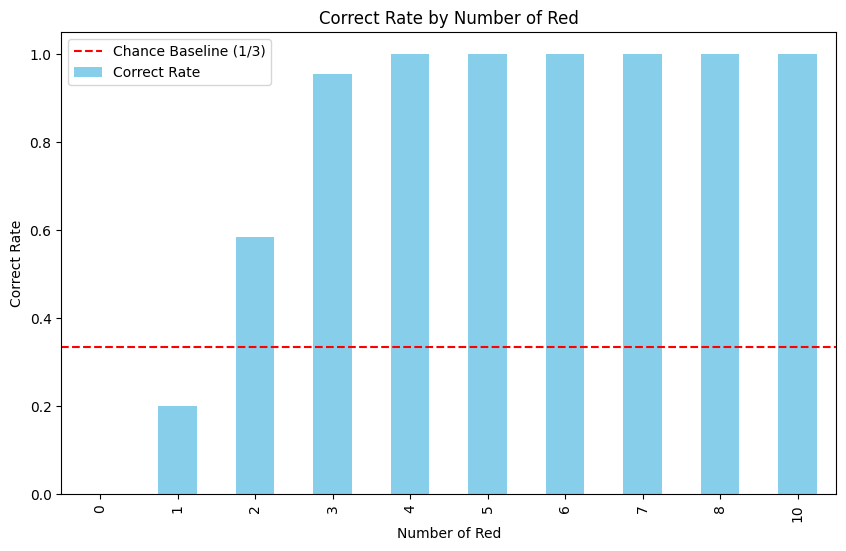

In [35]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming loc_df is your DataFrame containing the results
# Filter out trials where final_choice == 0
filtered_df = loc_df[loc_df['final_choice'] != 0]

# Calculate the correct rate for each num_red
correct_rate = filtered_df.groupby('num_red')['correct'].mean()

# Plot the correct rate
plt.figure(figsize=(10, 6))
correct_rate.plot(kind='bar', color='skyblue', label='Correct Rate')

# Add a horizontal line for the chance baseline at 1/3
plt.axhline(y=1/3, color='red', linestyle='--', label='Chance Baseline (1/3)')

# Add labels and title
plt.xlabel('Number of Red')
plt.ylabel('Correct Rate')
plt.title('Correct Rate by Number of Red')
plt.legend()

# Show the plot
plt.show()

In [15]:
grouped_stats = loc_df.groupby('num_red')['correct'].agg(['mean', 'var', 'count'])

# Print the statistics
print(grouped_stats)

             mean       var  count
num_red                           
1        0.083333  0.083333     12
2        0.583333  0.253623     24
3        0.875000  0.114130     24
4        0.947368  0.052632     19
5        0.769231  0.192308     13
6        1.000000  0.000000      5
7        1.000000  0.000000      9
8        1.000000  0.000000      9
10       1.000000  0.000000      5
